**CMLS - Homework 1 - Assignment 1: Musical Genre Classification**

Implement a classifier able to predict the musical genre of a music piece.

In [1]:
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp

from pathlib import Path

import IPython
#import essentia
#import essentia.standard as es

**Features Computation**

In [2]:
#We give as input the complete audio signal, without framing it

def compute_mfcc(audio, fs, n_mfcc):
    # First of all we code the first 2 steps: windowing and DFT
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # 3rd step: Find the weights of the mel filters
    mel = librosa.filters.mel(
        # Sampling frequency
        sr=fs,
        # Number used for the FFT
        n_fft=1024,
        # How many filters we want
        n_mels=40,
        # Minimum frequency on Mel Scale
        fmin=133.33,
        # Maximum frequency on Mel Scale
        fmax=6853.8,
        # These are just standard values used in the Mel Scale
    )
    
    # Apply the filters to spectrogram to get Y(m)
    melspectrogram = np.dot(mel, X)
    # Take the logarithm (I sum a small quantity in order to avoid log(0))
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1 : n_mfcc + 1]
    # The last parameter is to choose how many coefficients I want to use
    return mfcc

In [3]:
audiofiles = [str(file) for file in Path().glob('genres/jazz/train/*.wav')]
np.size(audiofiles)

66

**Features Computation**: training

In [4]:
classes = ['classical', 'disco', 'jazz', 'country']
n_mfcc = 16
n_chroma = 12
n_tempo = 1

dict_train_features_mfcc = {'classical': [], 'disco': [], 'jazz': [], 'country': []}
dict_train_features_tempo = {'classical': [], 'disco': [], 'jazz': [], 'country': []}


for c in classes:
    train_root = 'genres/{}/train/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')]    
    n_train_samples = len(class_train_files)
    
    train_features_mfcc = np.zeros((n_train_samples, n_mfcc))
    train_features_chroma = np.zeros((n_train_samples, n_chroma))
    train_features_tempo = np.zeros((n_train_samples, n_tempo))
    

    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        
        chroma_stft = librosa.feature.chroma_stft(y=audio, sr=fs)

        tempo, beat_times = librosa.beat.beat_track(audio, sr=fs, start_bpm=60, units='time')
        
        #print(tempo)
        #print(beat_times)
          
        train_features_mfcc[index, :] = np.mean(mfcc, axis=1)
        train_features_chroma[index, :] = np.mean(chroma_stft, axis=1)
        train_features_tempo[index, :] = tempo;
        
    dict_train_features_mfcc[c] = train_features_mfcc        #3D matrix of for each genre (genre*coefficient*sample)
    dict_train_features_tempo[c] = train_features_tempo
        

(-1.0, 1.0)

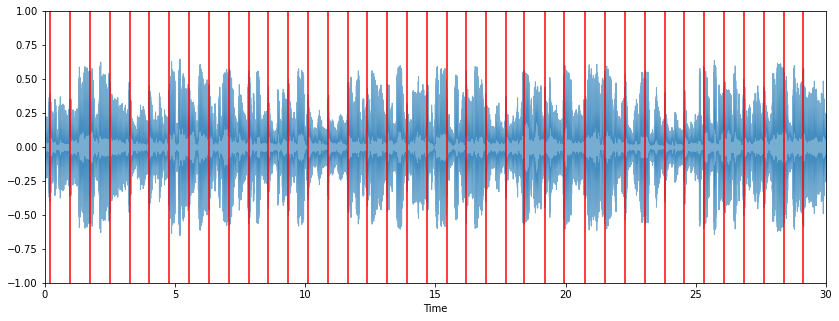

In [5]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio, alpha=0.6)
plt.vlines(beat_times, -1, 1, color='r')
plt.ylim(-1, 1)

(array([ 4.,  6.,  9.,  8., 11.,  9.,  4.,  8.,  4.,  3.]),
 array([43.06640625, 47.98828125, 52.91015625, 57.83203125, 62.75390625,
        67.67578125, 72.59765625, 77.51953125, 82.44140625, 87.36328125,
        92.28515625]),
 <BarContainer object of 10 artists>)

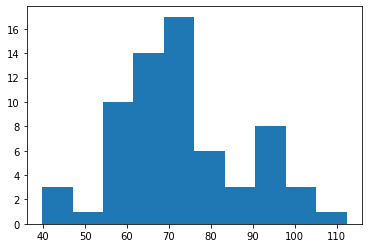

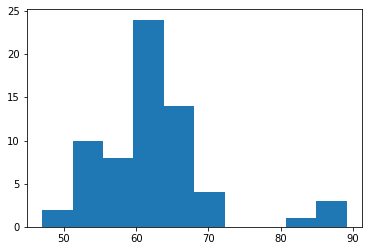

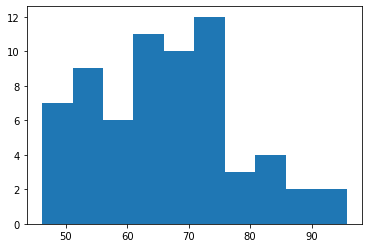

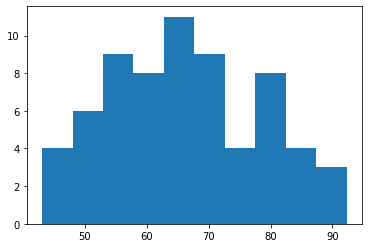

In [6]:
plt.figure(1)
plt.hist(dict_train_features_tempo['classical'])
plt.figure(2)
plt.hist(dict_train_features_tempo['disco'])
plt.figure(3)
plt.hist(dict_train_features_tempo['jazz'])
plt.figure(4)
plt.hist(dict_train_features_tempo['country'])

#plt.legend([line1, line2, line3, line4], ['label1', 'label2', 'label3'])

In [7]:
print(np.shape(train_features_mfcc))
print(np.shape(train_features_tempo))

(66, 16)
(66, 1)


In [8]:
dict_test_features_mfcc = {'classical': [], 'disco': [], 'jazz': [], 'country': []}

for c in classes:
    test_root = 'genres/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.wav')]
    n_test_samples = len(class_test_files)
    
    test_features_mfcc = np.zeros((n_test_samples, n_mfcc))
    test_features_chroma = np.zeros((n_test_samples, n_chroma))
    
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        
        chroma_stft = librosa.feature.chroma_stft(y=audio, sr=fs)

        test_features_mfcc[index, :] = np.mean(mfcc, axis=1)
        test_features_chroma[index, :] = np.mean(chroma_stft, axis=1)

    dict_test_features_mfcc[c] = test_features_mfcc         #3D matrix of for each genre (genre*coefficient*sample)
    

In [9]:
print(np.shape(test_features_mfcc))
print(np.shape(test_features_chroma))

(34, 16)
(34, 12)


In [ ]:
#Chromagram of train features

fig, ax = plt.subplots()
img = librosa.display.specshow(train_features_chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram')

In [ ]:
#Chromagram of test features (maybe not useful!)

fig, ax = plt.subplots()
img = librosa.display.specshow(test_features_chroma, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram')

In [ ]:
#Better understanding of this!!
#Maybe choose another plotting method

for c in classes:
    mfcc = dict_train_features_mfcc[c].transpose()
    
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

In [ ]:
#SVM

#def svm_features(dict_train_features_mfcc, dict_test_features_mfcc)

class_0 = 'classical'
class_1 = 'disco'
class_2 = 'jazz'
class_3 = 'country'

x_train_0 = dict_train_features_mfcc[class_0]
x_train_1 = dict_train_features_mfcc[class_1]
x_train_2 = dict_train_features_mfcc[class_2]
x_train_3 = dict_train_features_mfcc[class_3]

y_train_0 = np.zeros((x_train_0.shape[0],))
y_train_1 = np.ones((x_train_1.shape[0],))
y_train_2 = np.ones((x_train_2.shape[0],))*2
y_train_3 = np.ones((x_train_3.shape[0],))*3

y_train = np.concatenate((y_train_0, y_train_1, y_train_1, y_train_3), axis=0)

In [ ]:
x_test_0 = dict_test_features_mfcc[class_0]
x_test_1 = dict_test_features_mfcc[class_1]
x_test_2 = dict_test_features_mfcc[class_2]
x_test_3 = dict_test_features_mfcc[class_3]

y_test_0 = np.zeros((x_test_0.shape[0],))
y_test_1 = np.ones((x_test_1.shape[0],))
y_test_2 = np.ones((x_test_2.shape[0],))*2
y_test_3 = np.ones((x_test_3.shape[0],))*3

y_test = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3), axis=0)

In [ ]:
#Normalize features

feat_max = np.max(np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3), axis=0), axis=0)
feat_min = np.min(np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3), axis=0), axis=0)

x_train_0_normalized = (x_train_0 - feat_min) / (feat_max - feat_min)
x_train_1_normalized = (x_train_1 - feat_min) / (feat_max - feat_min)
x_train_2_normalized = (x_train_2 - feat_min) / (feat_max - feat_min)
x_train_3_normalized = (x_train_3 - feat_min) / (feat_max - feat_min)

x_test_0_normalized = (x_test_0 - feat_min) / (feat_max - feat_min)
x_test_1_normalized = (x_test_1 - feat_min) / (feat_max - feat_min)
x_test_2_normalized = (x_test_2 - feat_min) / (feat_max - feat_min)
x_test_3_normalized = (x_test_3 - feat_min) / (feat_max - feat_min)

x_test_normalized = np.concatenate((x_test_0_normalized, x_test_1_normalized, x_test_2_normalized, x_test_3_normalized), axis=0)

In [ ]:
#Define and train a model for each couple of classes

SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_03 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_13 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_23 = sklearn.svm.SVC(**SVM_parameters, probability=True)

In [ ]:
clf_01.fit(np.concatenate((x_train_0_normalized, x_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((x_train_0_normalized, x_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_03.fit(np.concatenate((x_train_0_normalized, x_train_3_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_3), axis=0))

clf_12.fit(np.concatenate((x_train_1_normalized, x_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

clf_13.fit(np.concatenate((x_train_1_normalized, x_train_3_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_3), axis=0))

clf_23.fit(np.concatenate((x_train_2_normalized, x_train_3_normalized), axis=0), 
           np.concatenate((y_train_2, y_train_3), axis=0))

In [ ]:
y_test_predicted_01 = clf_01.predict(x_test_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(x_test_normalized).reshape(-1, 1)
y_test_predicted_03 = clf_03.predict(x_test_normalized).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(x_test_normalized).reshape(-1, 1)
y_test_predicted_13 = clf_13.predict(x_test_normalized).reshape(-1, 1)
y_test_predicted_23 = clf_23.predict(x_test_normalized).reshape(-1, 1)

In [ ]:
#Majority voting

y_test_predicted = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_03, y_test_predicted_12, y_test_predicted_13, y_test_predicted_23), axis=1)
y_test_predicted = np.array(y_test_predicted, dtype=np.int)

y_test_predicted_mv = np.zeros((y_test_predicted.shape[0],))
for i, e in enumerate(y_test_predicted):
    y_test_predicted_mv[i] = np.bincount(e).argmax()


**Confusion Matrix computation**

In [ ]:
def compute_multiclass(gt, predicted):
    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1
            
    print(CM/34)

In [ ]:
compute_multiclass(y_test, y_test_predicted_mv)

In [ ]:
# Confusion matrix (UMUT)
# Do we have to normalize it??

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_predicted_mv)
cm = cm/34
classlist = ['classical', 'disco', 'jazz', 'country']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classlist)
disp.plot(cmap = 'Greys')

In [ ]:
#Evaluation metrics

def compute_metrics(gt_labels, predicted_labels):
    TP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 1))
    FP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 0))
    TN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 0))
    FN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 1))
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    print("Results : \n accuracy = {} \n precision = {} \n recall = {} \n F1 score = {}".format(
        accuracy, precision, recall, F1_score))

In [ ]:
print(np.shape(y_test))
print(y_test)
print(np.shape(y_test_predicted_mv))
print(y_test_predicted_mv)

In [ ]:
# Essentia library doesn't work!!!


# Compute all features, aggregate only 'mean' and 'stdev' statistics for all low-level, rhythm and tonal frame features
features, features_frames = essentia.MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                              rhythmStats=['mean', 'stdev'],
                                              tonalStats=['mean', 'stdev'])('genres/classical/train/classical.00050.wav')

# See all feature names in the pool in a sorted order
print(sorted(features.descriptorNames()))

In [ ]:
#IPython.display.Audio('genres/classical/train/classical.00001.wav')